In [19]:
"""
Diego Pires Silva
RA:239489
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import zipfile

# config
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [3]:
def getStats(chunk_df, pos=None):
    """
    Calcula estatísticas suficientes para cada chunk de dados
    """
    # Filtrar apenas companhias de interesse
    airlines = ['AA', 'DL', 'UA', 'US']
    chunk_filtered = chunk_df[chunk_df['AIRLINE'].isin(airlines)].copy()
    
    # dropar valores faltantes
    chunk_filtered = chunk_filtered.dropna(subset=['ARRIVAL_DELAY', 'YEAR', 'MONTH', 'DAY', 'AIRLINE'])
    
    if chunk_filtered.empty:
        return pd.DataFrame(columns=['YEAR', 'MONTH', 'DAY', 'AIRLINE', 'total_flights', 'delayed_flights'])
    
    # agrupar por dia
    stats = chunk_filtered.groupby(['YEAR', 'MONTH', 'DAY', 'AIRLINE']).agg({
        'ARRIVAL_DELAY': ['count', lambda x: (x > 10).sum()]
    }).reset_index()
    
    # Renomear colunas
    stats.columns = ['YEAR', 'MONTH', 'DAY', 'AIRLINE', 'total_flights', 'delayed_flights']
    
    return stats

In [4]:
def read_flight_data(file_path, chunk_size=100000):
    """
    Lê dados de voos em chunks e processa com getStats
    """
    all_stats = []
    
    # Colunas necessárias
    cols = ['YEAR', 'MONTH', 'DAY', 'AIRLINE', 'ARRIVAL_DELAY']
    
    try:
        # Se for arquivo zip
        if file_path.endswith('.zip'):
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                csv_file = zip_ref.namelist()[0]
                with zip_ref.open(csv_file) as f:
                    chunk_reader = pd.read_csv(f, chunksize=chunk_size, usecols=cols)
        else:
            chunk_reader = pd.read_csv(file_path, chunksize=chunk_size, usecols=cols)
        
        print(f"Processando em chunks de {chunk_size:,} registros...")
        
        for i, chunk in enumerate(chunk_reader):
            print(f"Chunk {i+1}: {len(chunk):,} registros")
            chunk_stats = getStats(chunk, i)
            if not chunk_stats.empty:
                all_stats.append(chunk_stats)
        
        # Combinar todos os chunks
        if all_stats:
            return pd.concat(all_stats, ignore_index=True)
        else:
            return pd.DataFrame()
            
    except Exception as e:
        print(f"Erro ao ler arquivo: {e}")
        return pd.DataFrame()

In [5]:
def computeStats(raw_stats):
    """
    Combina estatísticas suficientes para calcular percentuais finais
    """
    # Agrupar por data e companhia, somando totais
    final_stats = raw_stats.groupby(['YEAR', 'MONTH', 'DAY', 'AIRLINE']).agg({
        'total_flights': 'sum',
        'delayed_flights': 'sum'
    }).reset_index()
    
    # Calcular percentual de atraso
    final_stats['Perc'] = final_stats['delayed_flights'] / final_stats['total_flights']
    
    # Criar coluna de data
    final_stats['Data'] = pd.to_datetime(final_stats[['YEAR', 'MONTH', 'DAY']])
    
    # Selecionar apenas colunas necessárias
    result = final_stats[['AIRLINE', 'Data', 'Perc']].copy()
    result.rename(columns={'AIRLINE': 'Cia'}, inplace=True)
    
    return result

In [17]:
def baseCalendario(stats, cia):
    """
    Cria base de dados para calendário de uma companhia específica
    """
    try:
        # Filtrar dados da companhia
        cia_data = stats[stats['Cia'] == cia].copy()
        
        print(f"DEBUG baseCalendario - Dados para {cia}: {len(cia_data)} registros")
        
        if cia_data.empty:
            print(f"Aviso: Nenhum dado encontrado para a companhia {cia}")
            return pd.DataFrame()
        
        # Garantir que temos todos os dias do ano
        start_date = datetime(2015, 1, 1)
        end_date = datetime(2015, 12, 31)
        all_dates = pd.date_range(start_date, end_date, freq='D')
        
        # Criar DataFrame completo
        full_calendar = pd.DataFrame({'Data': all_dates})
        
        # Fazer merge apenas com as colunas necessárias
        merged = full_calendar.merge(cia_data[['Data', 'Perc']], on='Data', how='left')
        merged['Perc'] = merged['Perc'].fillna(0)
        merged['Cia'] = cia
        
        print(f"DEBUG baseCalendario - Calendário final para {cia}: {len(merged)} dias")
        
        return merged
        
    except Exception as e:
        print(f"Erro em baseCalendario para {cia}: {e}")
        return pd.DataFrame()

In [13]:
def plot_calendar_heatmap(calendar_data, cia_name):
    """
    Cria mapa de calor em formato calendário
    """
    if calendar_data is None or calendar_data.empty:
        print(f"Erro: Dados vazios para {cia_name}")
        return
    
    # Configurar paleta de cores
    colors = ['#4575b4', '#d73027']
    n_bins = 100
    cmap = plt.cm.colors.LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Preparar dados - fazer uma cópia para evitar modificar o original
    data = calendar_data.copy()
    data['month'] = data['Data'].dt.month
    data['day'] = data['Data'].dt.day
    data['weekday'] = data['Data'].dt.weekday
    
    # Calcular semana do ano de forma mais simples
    data['week_of_year'] = data['Data'].dt.isocalendar().week
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(f'Percentual de Atrasos - {cia_name} (2015)', fontsize=18, y=0.95)
    
    months = range(1, 13)
    month_names = [calendar.month_name[i] for i in months]
    
    for i, month in enumerate(months):
        row, col = i // 4, i % 4
        ax = axes[row, col]
        
        # Dados do mês
        month_data = data[data['month'] == month].copy()
        
        if month_data.empty:
            ax.set_title(month_names[i])
            ax.text(0.5, 0.5, 'Sem dados', ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
            continue
        
        # Criar uma matriz simples baseada nos dias do mês
        # Vamos usar uma abordagem mais simples
        max_day = month_data['day'].max()
        first_weekday = datetime(2015, month, 1).weekday()
        
        # Calcular quantas semanas precisamos
        total_days = (max_day + first_weekday)
        weeks_needed = int(np.ceil(total_days / 7))
        
        # Criar matriz do calendário
        calendar_matrix = np.full((7, weeks_needed), np.nan)
        day_matrix = np.full((7, weeks_needed), '', dtype=object)
        
        # Preencher a matriz
        for _, row in month_data.iterrows():
            day_of_month = row['day']
            # Calcular posição na matriz
            total_pos = first_weekday + day_of_month - 1
            week_pos = total_pos // 7
            day_pos = total_pos % 7
            
            if week_pos < weeks_needed:
                calendar_matrix[day_pos, week_pos] = row['Perc']
                day_matrix[day_pos, week_pos] = str(day_of_month)
        
        # Plotar heatmap
        im = ax.imshow(calendar_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=data['Perc'].max())
        
        # Configurar eixos
        ax.set_title(month_names[i], fontsize=14, pad=10)
        ax.set_yticks(range(7))
        ax.set_yticklabels(['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'])
        ax.set_xticks(range(weeks_needed))
        ax.set_xticklabels([f'S{w+1}' for w in range(weeks_needed)])
        
        # Adicionar números dos dias
        for week_idx in range(weeks_needed):
            for day_idx in range(7):
                if day_matrix[day_idx, week_idx] != '':
                    color = 'white' if calendar_matrix[day_idx, week_idx] > 0.5 else 'black'
                    ax.text(week_idx, day_idx, day_matrix[day_idx, week_idx], 
                           ha='center', va='center', fontsize=8, color=color, weight='bold')
    
    # Adicionar colorbar
    plt.tight_layout()
    cbar = plt.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
    cbar.set_label('Percentual de Atraso', rotation=270, labelpad=20)
    
    plt.show()

Iniciando processamento...
Processando em chunks de 100,000 registros...
Chunk 1: 100,000 registros
Chunk 2: 100,000 registros
Chunk 3: 100,000 registros
Chunk 4: 100,000 registros
Chunk 5: 100,000 registros
Chunk 6: 100,000 registros
Chunk 7: 100,000 registros
Chunk 8: 100,000 registros
Chunk 9: 100,000 registros
Chunk 10: 100,000 registros
Chunk 11: 100,000 registros
Chunk 12: 100,000 registros
Chunk 13: 100,000 registros
Chunk 14: 100,000 registros
Chunk 15: 100,000 registros
Chunk 16: 100,000 registros
Chunk 17: 100,000 registros
Chunk 18: 100,000 registros
Chunk 19: 100,000 registros
Chunk 20: 100,000 registros
Chunk 21: 100,000 registros
Chunk 22: 100,000 registros
Chunk 23: 100,000 registros
Chunk 24: 100,000 registros
Chunk 25: 100,000 registros
Chunk 26: 100,000 registros
Chunk 27: 100,000 registros
Chunk 28: 100,000 registros
Chunk 29: 100,000 registros
Chunk 30: 100,000 registros
Chunk 31: 100,000 registros
Chunk 32: 100,000 registros
Chunk 33: 100,000 registros
Chunk 34: 10

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


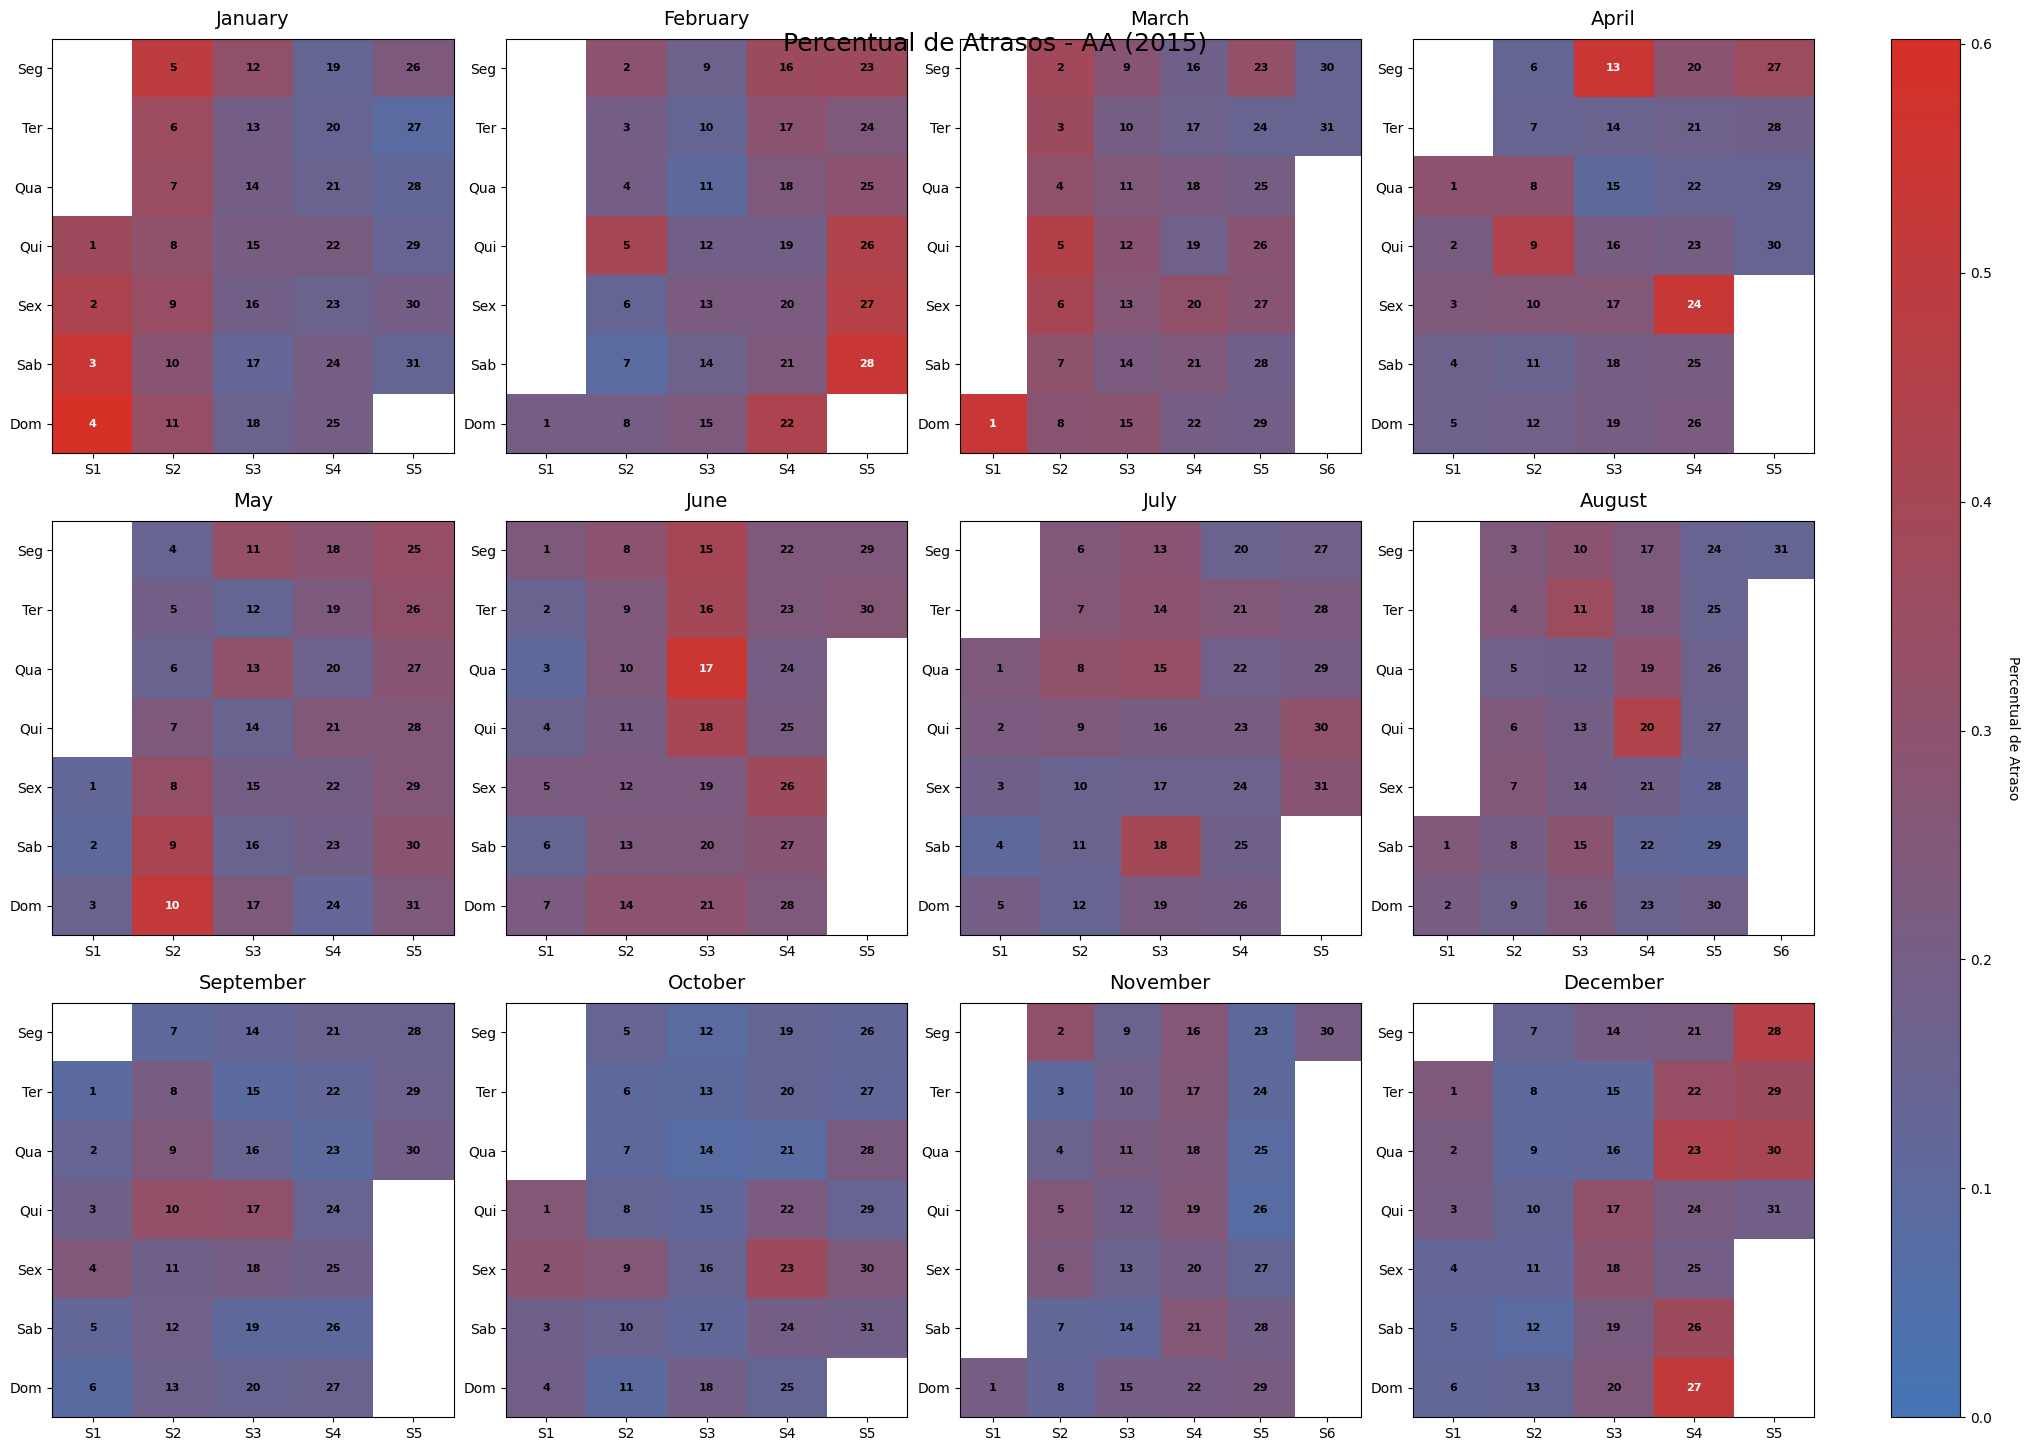


Gerando calendário para DL...
DEBUG baseCalendario - Dados para DL: 365 registros
DEBUG baseCalendario - Calendário final para DL: 365 dias


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


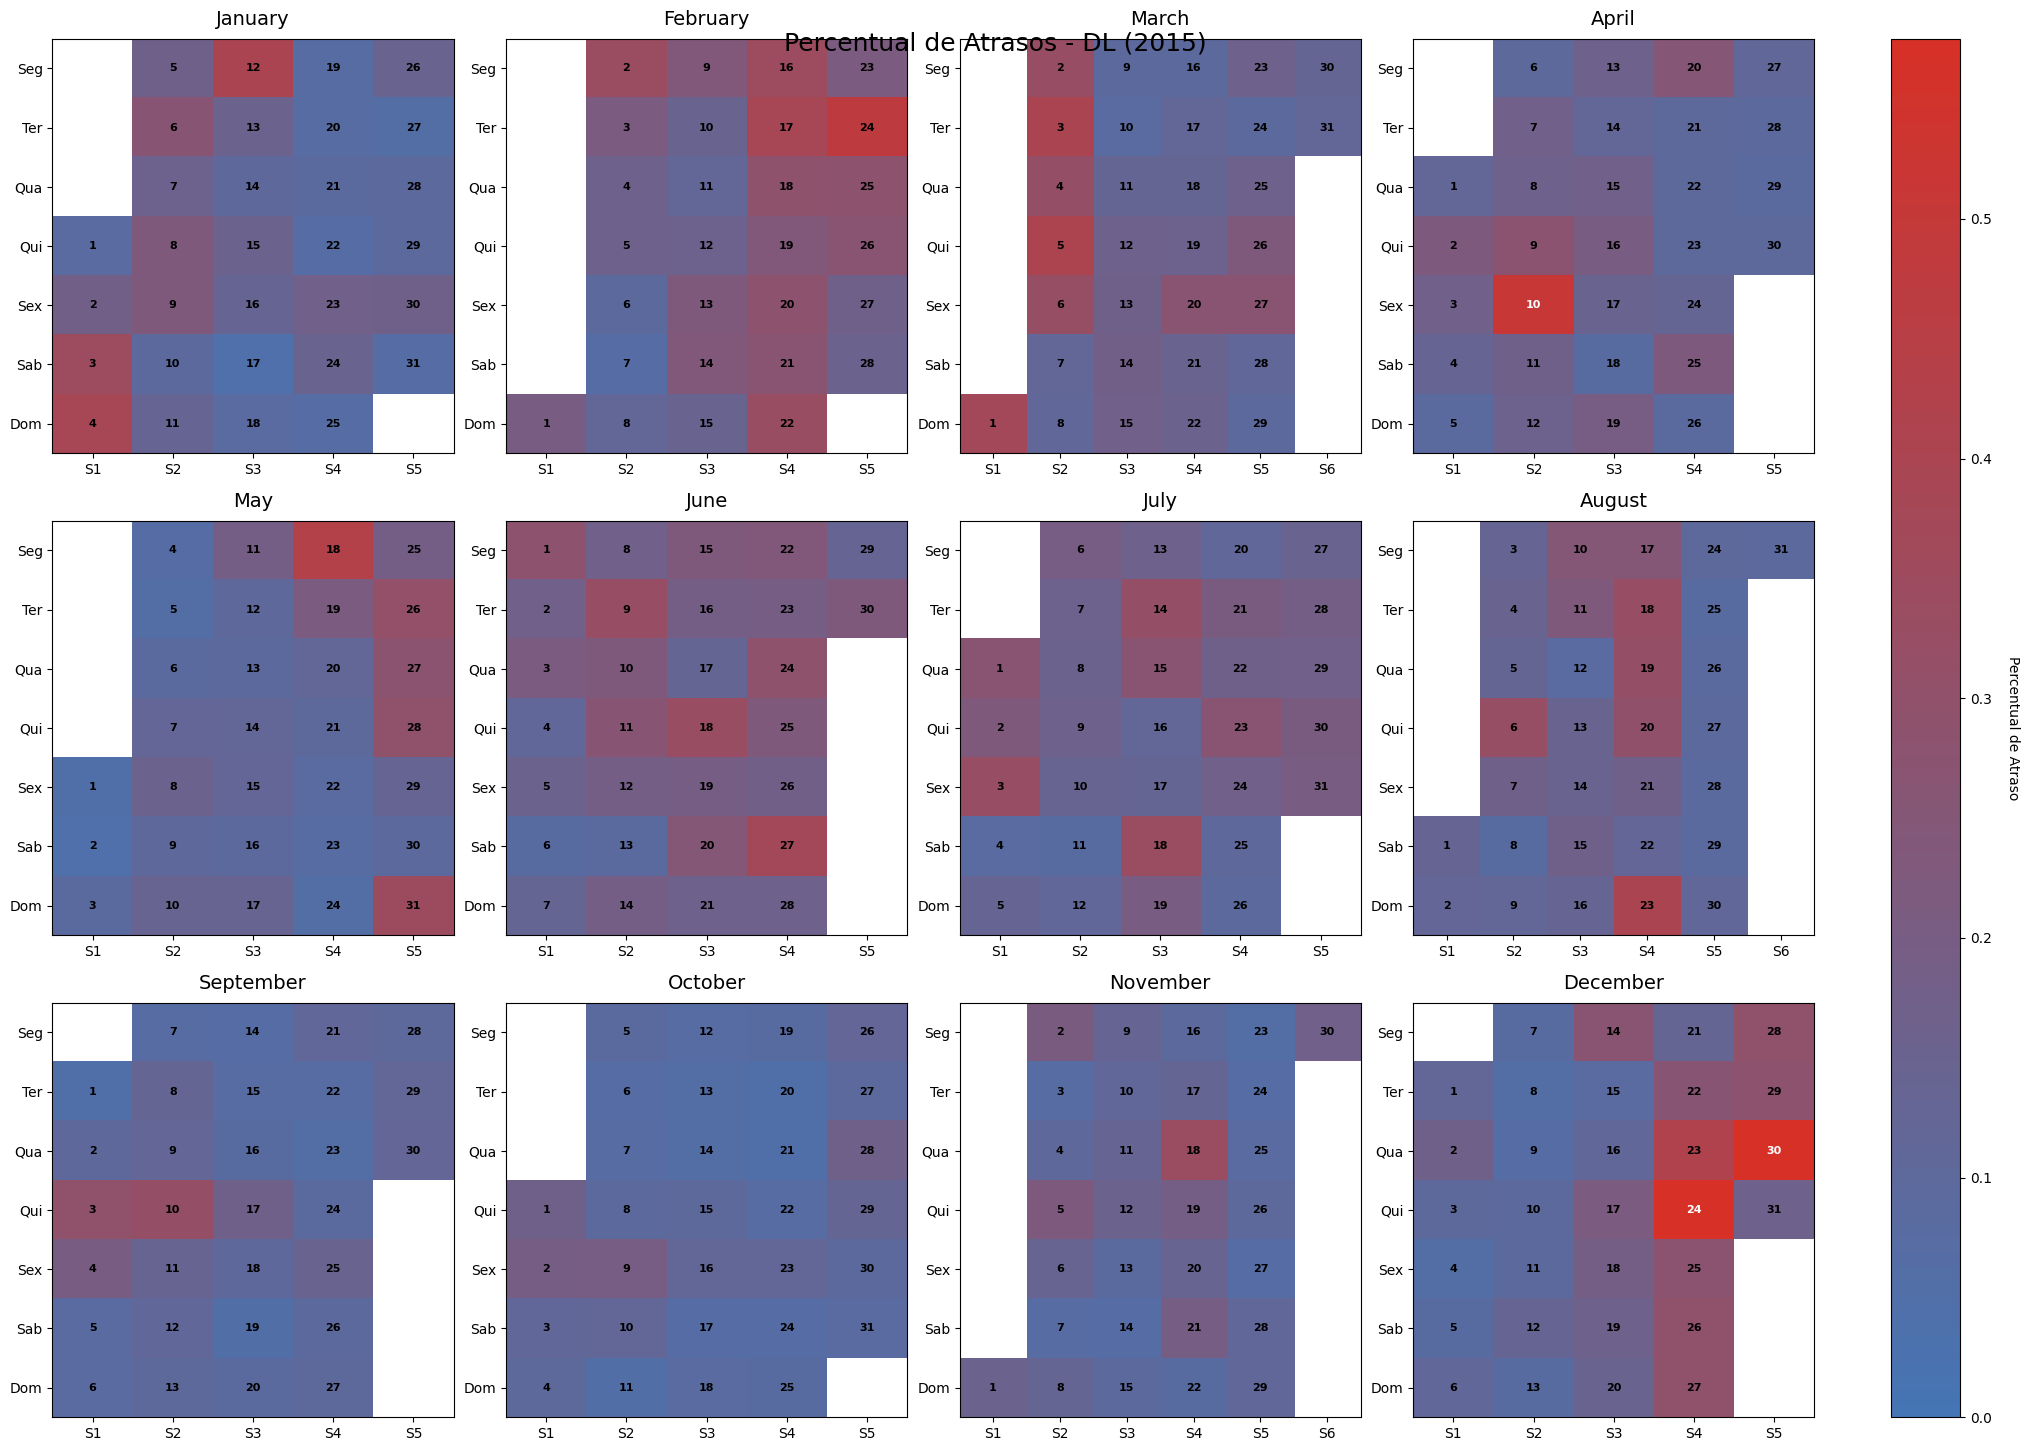


Gerando calendário para UA...
DEBUG baseCalendario - Dados para UA: 365 registros
DEBUG baseCalendario - Calendário final para UA: 365 dias


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


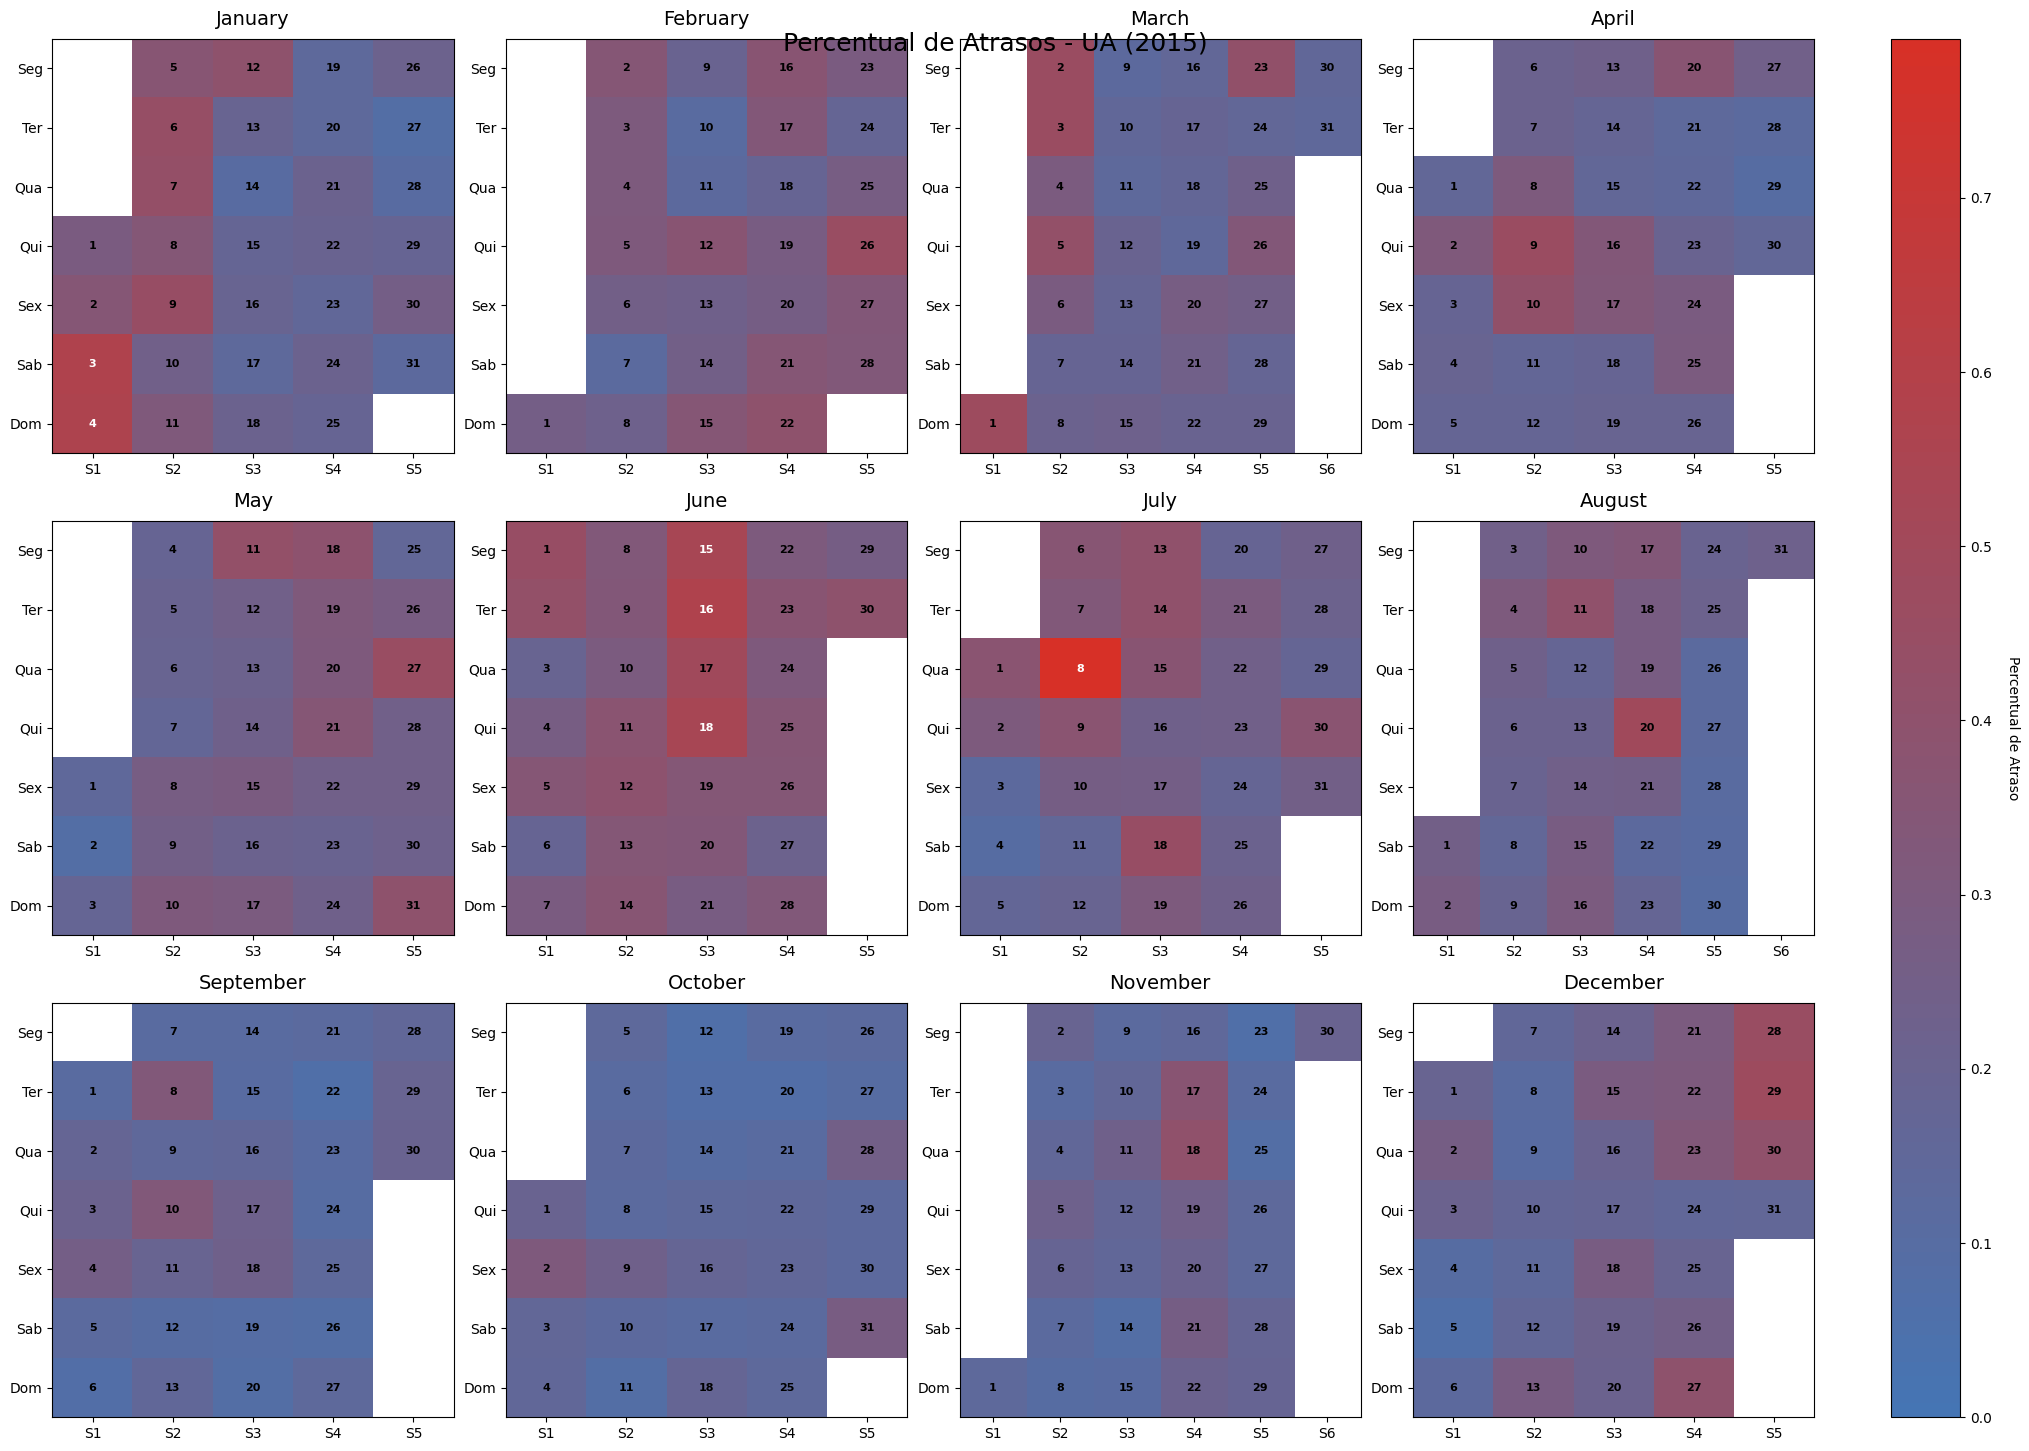


Gerando calendário para US...
DEBUG baseCalendario - Dados para US: 181 registros
DEBUG baseCalendario - Calendário final para US: 365 dias


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


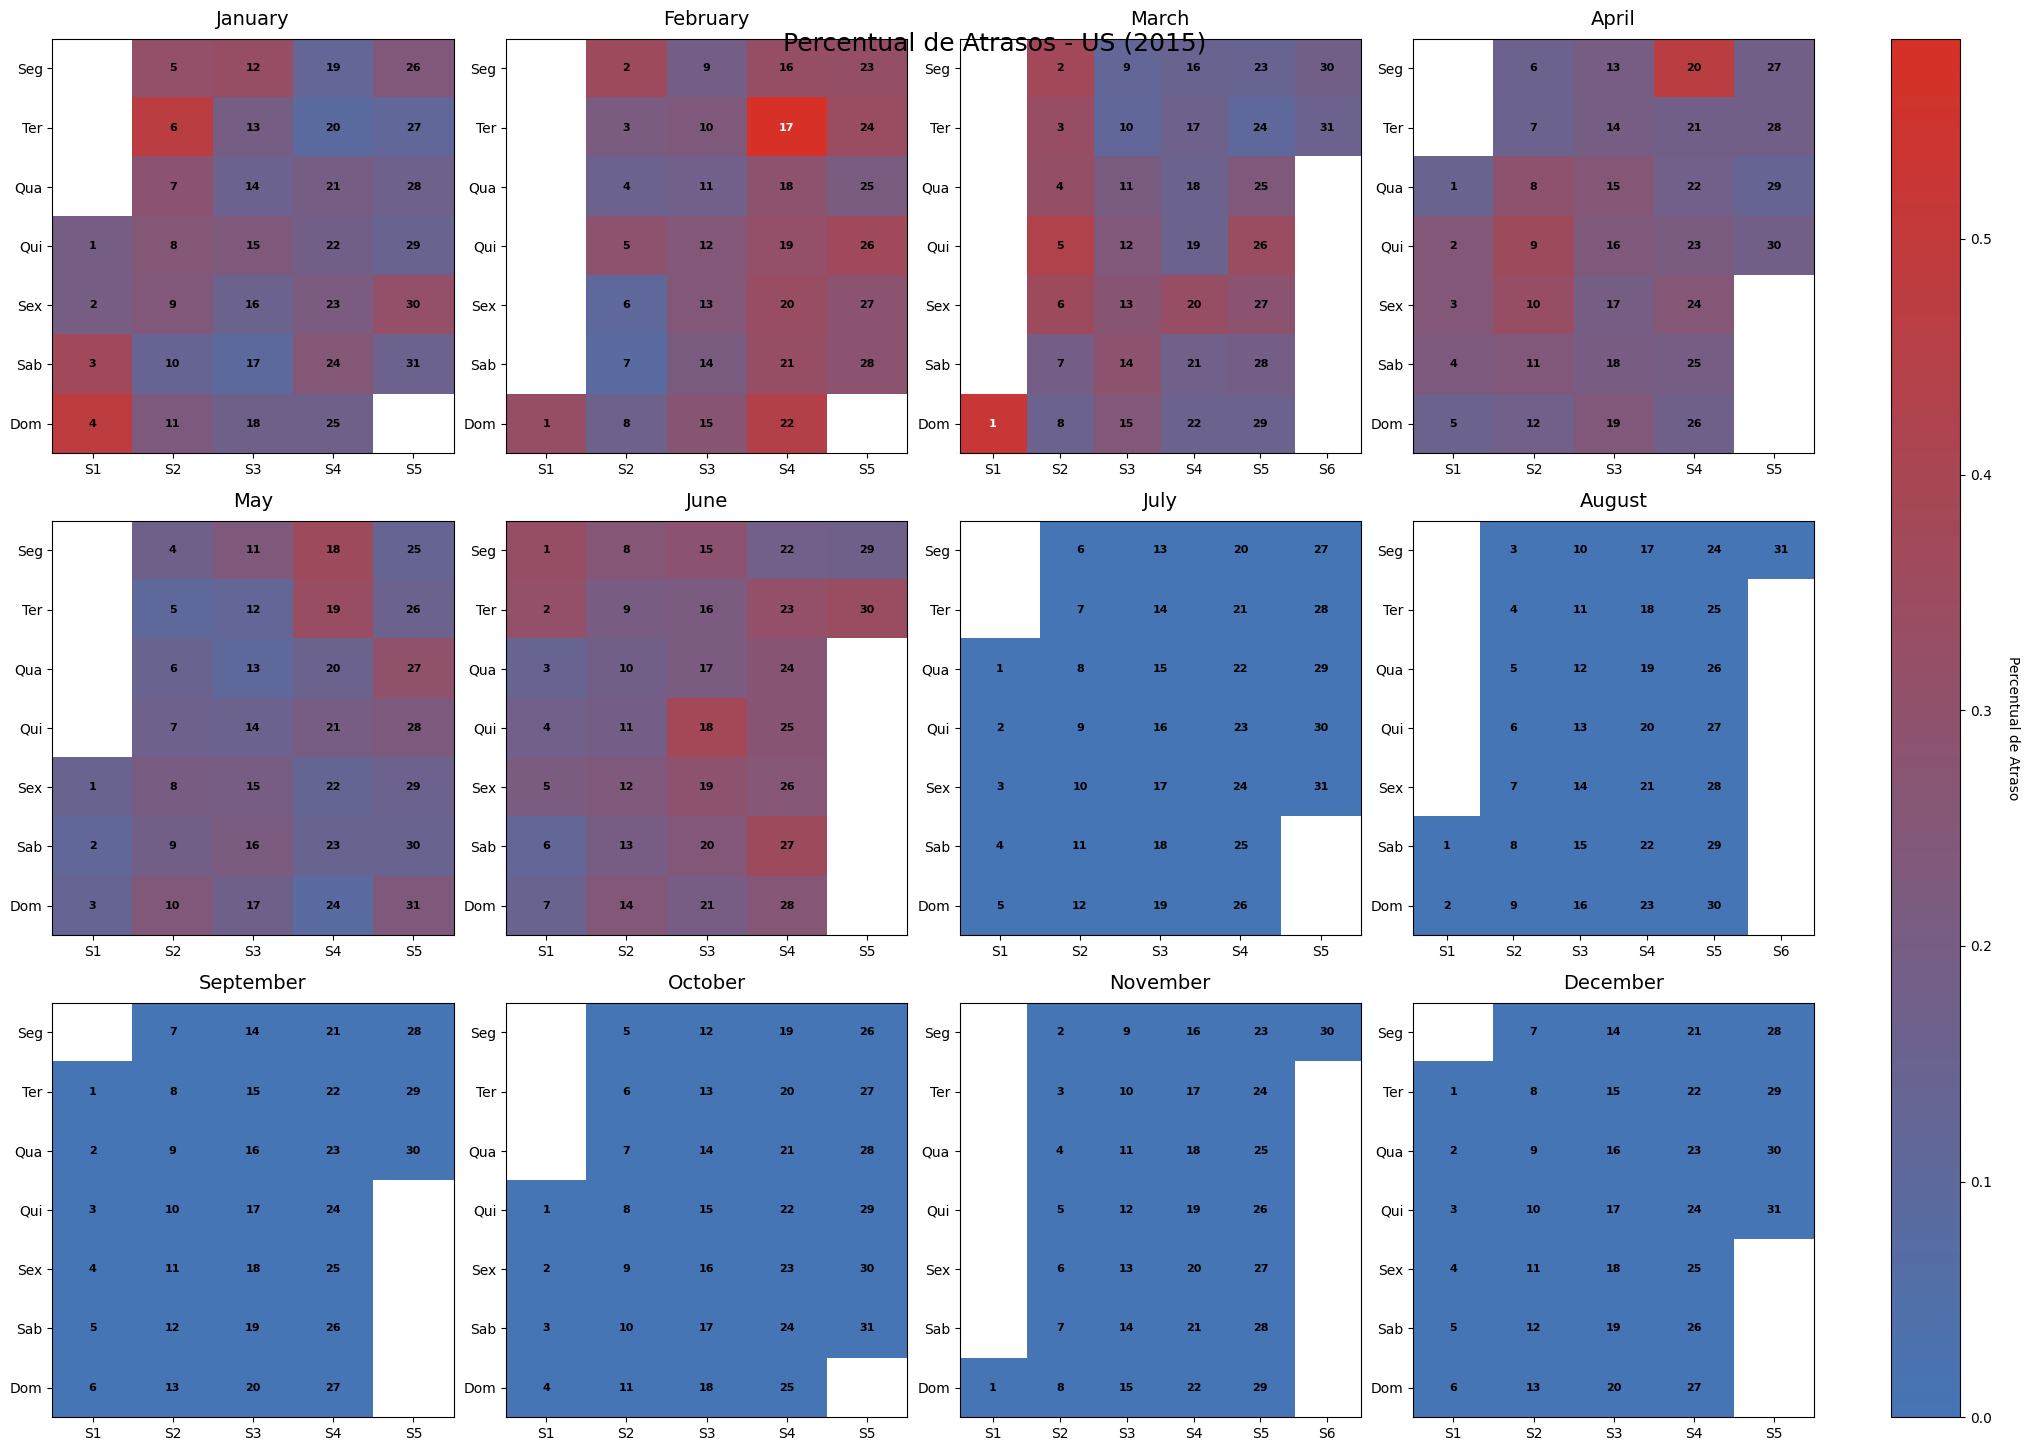

In [18]:
file_path = '/kaggle/input/flights/flights.csv'  # ALTERE AQUI O CAMINHO DO SEU ARQUIVO

print("Iniciando processamento...")
raw_stats = read_flight_data(file_path, chunk_size=100000)

if not raw_stats.empty:
    print("\nCalculando estatísticas finais...")
    final_stats = computeStats(raw_stats)
    
    print(f"\nResumo dos dados:")
    print(f"Período: {final_stats['Data'].min().date()} a {final_stats['Data'].max().date()}")
    print(f"Companhias: {sorted(final_stats['Cia'].unique())}")
    print(f"Total de registros: {len(final_stats):,}")
    
    # Estatísticas por companhia
    print("\nPercentual médio de atrasos por companhia:")
    avg_delays = final_stats.groupby('Cia')['Perc'].mean().sort_values(ascending=False)
    for cia, perc in avg_delays.items():
        print(f"{cia}: {perc:.1%}")
else:
    print("Erro: Não foi possível processar os dados.")

# CÉLULA 8: Gerar calendários para cada companhia
if 'final_stats' in locals() and not final_stats.empty:
    airlines = ['AA', 'DL', 'UA', 'US']
    
    for cia in airlines:
        print(f"\nGerando calendário para {cia}...")
        calendar_data = baseCalendario(final_stats, cia)
        plot_calendar_heatmap(calendar_data, cia)
else:
    print("Execute primeiro as células anteriores para carregar os dados.")

Estou conseguindo rodar os calendários mas algum erro está ocorrendo que não estou conseguindo resolver (acredito que a implementação dos calendários esteja correta).